In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stat
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import pickle
from sklearn.metrics import *
import pandas as pd
import seaborn as sns
sns.set_theme()
import statsmodels

In [2]:
from all_models import *

In [22]:
# read fit values
fits_single = pickle.load(open('fit_single_CV_640.pickle', 'rb'))
fits_dual = pickle.load(open('fit_dual_CV_640.pickle', 'rb'))
#fits_six = pickle.load(open('fit_six_CV_704.pickle', 'rb'))
#fits_mixed = pickle.load(open('fit_mixed_CV_704.pickle', 'rb'))
#fits_single_transfer = pickle.load(open('fit_single_CV_transfer.pickle', 'rb'))
#fits_dual_transfer = pickle.load(open('fit_dual_CV_transfer.pickle', 'rb'))

curvatures_smooth = pickle.load(open('curvatures_smooth.pickle', 'rb'))
curvatures_smooth = curvatures_smooth/90.0
curvatures = pickle.load(open('curvatures.pickle', 'rb'))

In [23]:
A = np.mean(fits_single, axis = 0)[:, 0]
B = np.mean(fits_single, axis = 0)[:, 1]
Af = np.mean(fits_dual, axis = 0)[:, 0]
Bf = np.mean(fits_dual, axis = 0)[:, 1]
As = np.mean(fits_dual, axis = 0)[:, 2]
Bs = np.mean(fits_dual, axis = 0)[:, 3]
"""
A_transfer = np.mean(fits_single_transfer, axis = 0)[:, 0]
B_transfer = np.mean(fits_single_transfer, axis = 0)[:, 1]
Af_transfer = np.mean(fits_dual_transfer, axis = 0)[:, 0]
Bf_transfer = np.mean(fits_dual_transfer, axis = 0)[:, 1]
As_transfer = np.mean(fits_dual_transfer, axis = 0)[:, 2]
Bs_transfer = np.mean(fits_dual_transfer, axis = 0)[:, 3]
"""

'\nA_transfer = np.mean(fits_single_transfer, axis = 0)[:, 0]\nB_transfer = np.mean(fits_single_transfer, axis = 0)[:, 1]\nAf_transfer = np.mean(fits_dual_transfer, axis = 0)[:, 0]\nBf_transfer = np.mean(fits_dual_transfer, axis = 0)[:, 1]\nAs_transfer = np.mean(fits_dual_transfer, axis = 0)[:, 2]\nBs_transfer = np.mean(fits_dual_transfer, axis = 0)[:, 3]\n'

In [24]:
d = {'Rotation': np.ravel(np.row_stack((np.repeat('Sudden', 30), np.repeat('Gradual', 30)))),
     'Emphasis': np.ravel(np.row_stack((np.repeat('Speed', 15), np.repeat('Accuracy', 15), np.repeat('Speed', 15), np.repeat('Accuracy', 15)))),
     'A': np.concatenate((A[0::4], A[1::4], A[2::4], A[3::4])),
     'B': np.concatenate((B[0::4], B[1::4], B[2::4], B[3::4])),
     'Af': np.concatenate((Af[0::4], Af[1::4], Af[2::4], Af[3::4])),
     'Bf': np.concatenate((Bf[0::4], Bf[1::4], Bf[2::4], Bf[3::4])),
     'As': np.concatenate((As[0::4], As[1::4], As[2::4], As[3::4])),
     'Bs': np.concatenate((Bs[0::4], Bs[1::4], Bs[2::4], Bs[3::4]))
     #'A_transfer': np.concatenate((A_transfer[0::4], A_transfer[1::4], A_transfer[2::4], A_transfer[3::4])),
     #'B_transfer': np.concatenate((B_transfer[0::4], B_transfer[1::4], B_transfer[2::4], B_transfer[3::4])),
     #'Af_transfer': np.concatenate((Af_transfer[0::4], Af_transfer[1::4], Af_transfer[2::4], Af_transfer[3::4])),
     #'Bf_transfer': np.concatenate((Bf_transfer[0::4], Bf_transfer[1::4], Bf_transfer[2::4], Bf_transfer[3::4])),
     #'As_transfer': np.concatenate((As_transfer[0::4], As_transfer[1::4], As_transfer[2::4], As_transfer[3::4])),
     #'Bs_transfer': np.concatenate((Bs_transfer[0::4], Bs_transfer[1::4], Bs_transfer[2::4], Bs_transfer[3::4]))
    }


In [25]:
parameters = pd.DataFrame(d)
melted = pd.melt(parameters, id_vars=['Rotation','Emphasis'], var_name='params', value_name='Mean Parameter Values')


(0.0, 1.0)

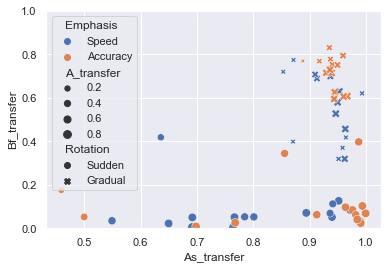

In [26]:
g = sns.scatterplot(x="As_transfer", y="Bf_transfer", hue="Emphasis", style = 'Rotation', data=parameters)
plt.ylim((0, 1))

(0.0, 1.0)

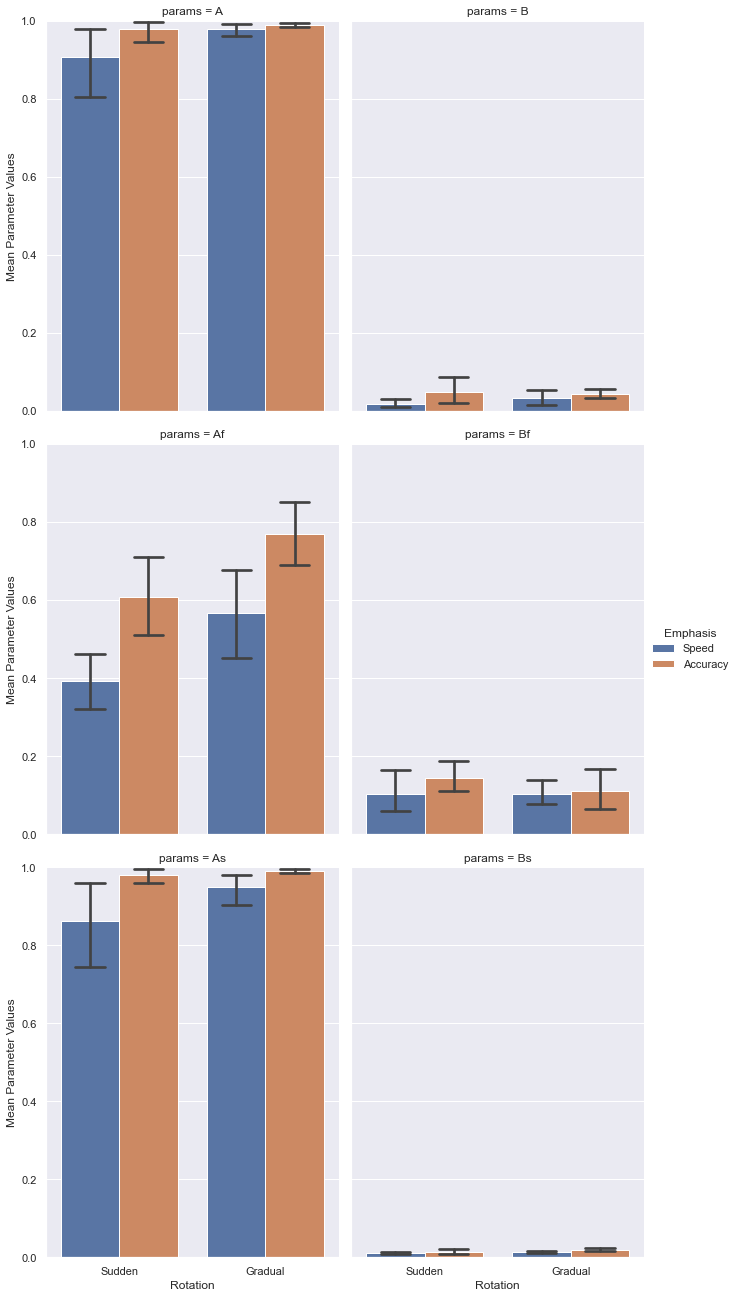

In [27]:
g = sns.catplot(x="Rotation", y="Mean Parameter Values", hue="Emphasis", col = 'params',
                col_wrap=2, col_order = ['A', 'B', 
                                         'Af', 'Bf', 
                                        'As', 'Bs',],
                capsize=.2, height=6, aspect=.75,ci = 95,
                kind = 'bar', data=melted)

plt.ylim((0, 1))


In [94]:
g.savefig('parameters.png', dpi = 600)